**Credit Card Fraud Detection**

**Problem Statement:-**

The aim of this project is to identify the fraudulent credit card transactions for given class imbalance ratio.

**Import the necessary libraries**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split,cross_val_predict,cross_val_score
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,auc,classification_report,roc_auc_score
from scikitplot.metrics import plot_confusion_matrix,plot_precision_recall_curve

import lightgbm as lgb
from scipy.stats import randint as sp_randint
from sklearn.model_selection import StratifiedKFold

import os
print(os.listdir("../input"))
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')


Using TensorFlow backend.


['creditcard.csv']


**Exploratery Data Analysis**

**Import the dataset**

**Where variables from V1-V28 is generated by PCA reduction technique.**

In [2]:
#import the training dataset
cc_df=pd.read_csv('../input/creditcard.csv')
cc_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


**Shape of the dataset**

In [3]:
#Shape of the dataset
cc_df.shape

(284807, 31)

**Target classes count**

0    284315
1       492
Name: Class, dtype: int64


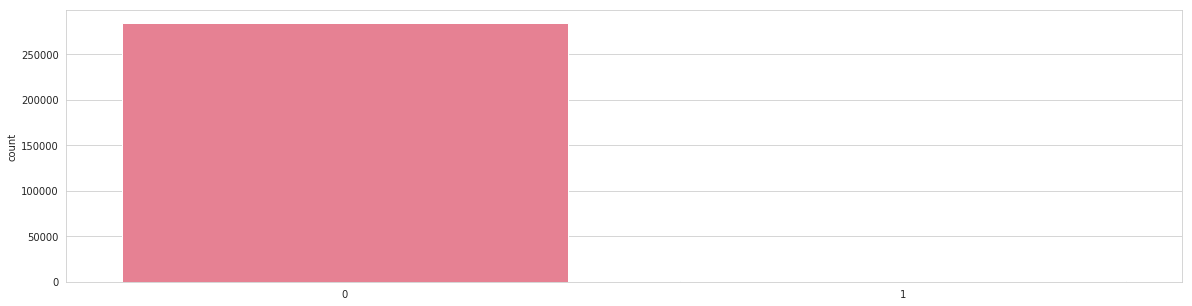

In [4]:
#count of target classes
print(cc_df['Class'].value_counts())
#count for target classes
fig,ax=plt.subplots(figsize=(20,5))
sns.countplot(cc_df.Class.values,palette='husl')

**Typecasting of attributes**

**Normalize the class labels**

In [5]:
#Percentage of target classes count
cc_df['Class'].value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

We can observed that 99.8% of data is non fraud credit card transaction and 0.17% of data is fraud transaction.Dataset is highly imbalanced.

**Distribution of attributes**

<Figure size 432x288 with 0 Axes>

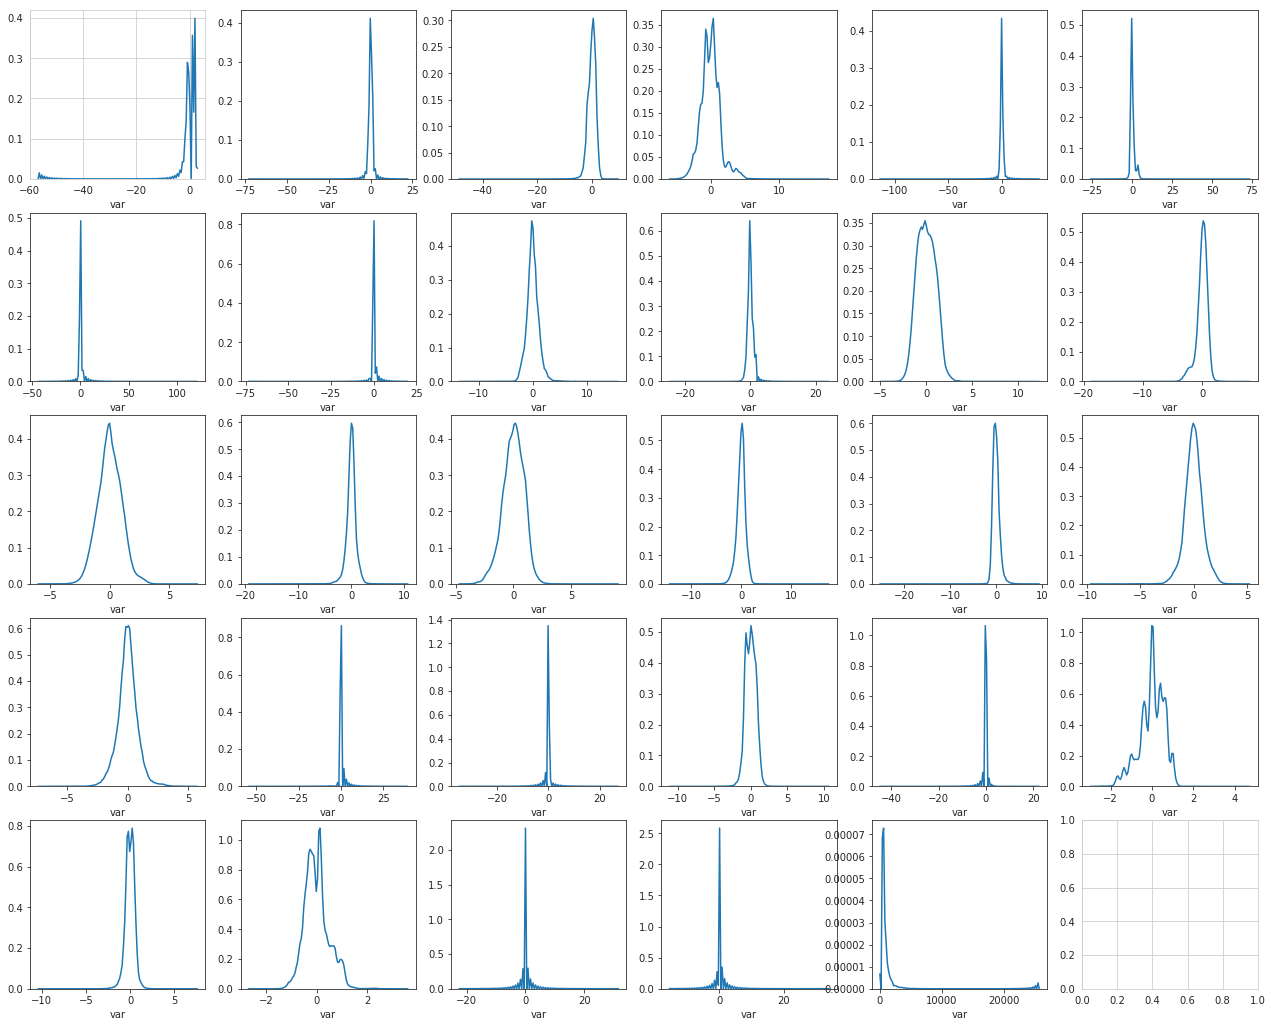

CPU times: user 5.92 s, sys: 2.52 s, total: 8.44 s
Wall time: 5.6 s


In [6]:
%%time
#Distribution of attributes
attributes=cc_df.columns.values[1:30]
def plot_attribute_distribution(attributes):
    i=0
    sns.set_style('whitegrid')
    
    fig=plt.figure()
    ax=plt.subplots(5,6,figsize=(22,18))
    
    for var in attributes:
        i+=1
        plt.subplot(5,6,i)
        sns.distplot(cc_df[var],hist=False)
        plt.xlabel('var',)
        sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
    plt.show()

plot_attribute_distribution(attributes)

**Normalization of Amount variable**

In [7]:
#normalized the amount variable by using standard scaler
ss=StandardScaler()
#convert to numpy array
amount=np.array(cc_df['Amount']).reshape(-1,1)
#fit transform the data
amount_ss=ss.fit_transform(amount)
#Create a dataframe
amount_df=pd.DataFrame(amount_ss,columns=['Amount'])
amount_df.head()

,Amount
0,0.244964
1,-0.342475
2,1.160686
3,0.140534
4,-0.073403


**Drop the old amount variable**

In [8]:
#Drop the amount variable
cc_df=cc_df.drop(['Amount'],axis=1)
cc_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


**Adding normalized Amount variable to training data**

In [9]:
#Creating the amount variable
cc_df['Amount']=amount_df
cc_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


**Split the training dataset 

In [10]:
%%time
#Training data
X=cc_df.drop(['Time','Class'],axis=1)
Y=cc_df['Class']

X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.25)
print('Shape of X_train :',X_train.shape)
print('Shape of X_test:',X_test.shape)
print('Shape of y_train :',y_test.shape)
print('Shape of y_test :',y_test.shape)

Shape of X_train : (213605, 29)
Shape of X_test: (71202, 29)
Shape of y_train : (71202,)
Shape of y_test : (71202,)
CPU times: user 100 ms, sys: 312 ms, total: 412 ms
Wall time: 412 ms


**Split the training dataset to train and validation dataset**

In [11]:
%%time
x=X_train
y=y_train
#StratifiedKFold cross validator
cv=StratifiedKFold(n_splits=5,random_state=42)
for train_index,valid_index in cv.split(x,y):
    X_t, X_v=x.iloc[train_index], x.iloc[valid_index]
    y_t, y_v=y.iloc[train_index], y.iloc[valid_index]

print('Shape of X_train :',X_t.shape)
print('Shape of X_test:',X_v.shape)
print('Shape of y_train :',y_t.shape)
print('Shape of y_test :',y_v.shape)

Shape of X_train : (170885, 29)
Shape of X_test: (42720, 29)
Shape of y_train : (170885,)
Shape of y_test : (42720,)
CPU times: user 104 ms, sys: 208 ms, total: 312 ms
Wall time: 306 ms


**Synthetic Minority Oversampling Technique(SMOTE)**

SMOTE uses a nearest neighbors algorithm to generate new and synthetic data to balance the imbalance data used for training the model.

In [12]:
%%time
#Synthetic Minority Oversampling Technique
sm = SMOTE(random_state=42, ratio=1.0)
#Generating synthetic data points
X_smote,y_smote=sm.fit_sample(X_t,y_t)
X_smote_v,y_smote_v=sm.fit_sample(X_v,y_v)
print('shape of X_smote :',X_smote.shape)
print('Shape of y_smote :',y_smote.shape)
print('shape of X_smote_v :',X_smote_v.shape)
print('Shape of y_smote_v :',y_smote_v.shape)

shape of X_smote : (341178, 29)
Shape of y_smote : (341178,)
shape of X_smote_v : (85294, 29)
Shape of y_smote_v : (85294,)
CPU times: user 1.13 s, sys: 220 ms, total: 1.35 s
Wall time: 1.35 s


Let us see how baseline logistic regression model performs on synthetic data points.

In [13]:
%%time
#Logistic regression model for SMOTE
smote=LogisticRegression(random_state=42)
#fitting the smote model
smote.fit(X_smote,y_smote)

CPU times: user 6.99 s, sys: 228 ms, total: 7.22 s
Wall time: 7.22 s


**Accuracy of model**

In [14]:
#Accuracy of the model
smote_score=smote.score(X_smote,y_smote)
print('Accuracy of the smote_model :',smote_score)

Accuracy of the smote_model : 0.9495043642907808


**Cross validation prediction of smoth_model**

In [15]:
%%time
#Cross validation prediction
cv_pred=cross_val_predict(smote,X_smote_v,y_smote_v,cv=5)
#Cross validation score
cv_score=cross_val_score(smote,X_smote_v,y_smote_v,cv=5)
print('cross_val_score :',np.average(cv_score))

cross_val_score : 0.9666213691732655
CPU times: user 25.5 s, sys: 3.26 s, total: 28.7 s
Wall time: 25.2 s


**Model performance on test data**

In [16]:
%%time
#Predicting the model
smote_pred=smote.predict(X_test)
print(smote_pred)

[0 0 0 ... 0 0 1]
CPU times: user 0 ns, sys: 20 ms, total: 20 ms
Wall time: 5.05 ms


**Confusion matrix**

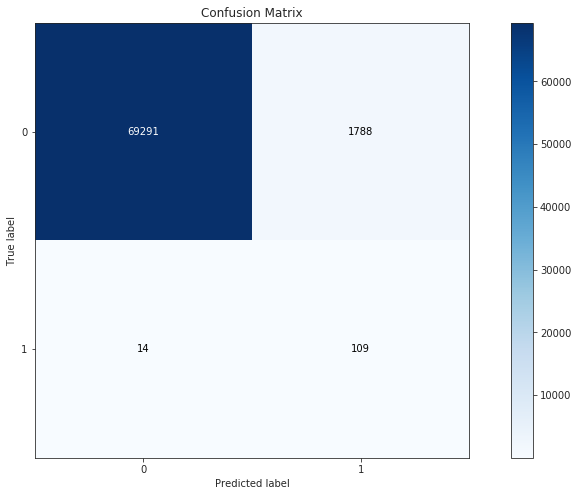

In [17]:
#Confusion matrix
cm=confusion_matrix(y_test,smote_pred)
#Plot the confusion matrix
plot_confusion_matrix(y_test,smote_pred,normalize=False,figsize=(15,8))

**Reciever operating characteristics (ROC)-Area under curve(AUC) score and curve**

ROC score : 0.9305118763423316


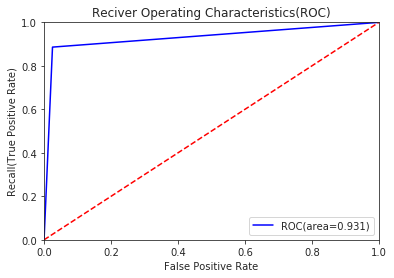

In [18]:
#ROC_AUC score
roc_score=roc_auc_score(y_test,smote_pred)
print('ROC score :',roc_score)

#ROC_AUC curve
plt.figure()
false_positive_rate,recall,thresholds=roc_curve(y_test,smote_pred)
roc_auc=auc(false_positive_rate,recall)
plt.title('Reciver Operating Characteristics(ROC)')
plt.plot(false_positive_rate,recall,'b',label='ROC(area=%0.3f)' %roc_auc)
plt.legend()
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall(True Positive Rate)')
plt.xlabel('False Positive Rate')
plt.show()

**Classification report**

In [19]:
#Classification report
scores=classification_report(y_test,smote_pred)
print(scores)

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     71079
           1       0.06      0.89      0.11       123

   micro avg       0.97      0.97      0.97     71202
   macro avg       0.53      0.93      0.55     71202
weighted avg       1.00      0.97      0.99     71202



**Training the lgbm model**

In [20]:
%%time
#train data
lgb_train=lgb.Dataset(X_t,y_t)
#validation data
lgb_valid=lgb.Dataset(X_v,y_v)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 45.1 µs


**Choosing the hyperparameters**

In [21]:
#choosing the hyperparameters
params={'boosting_type': 'gbdt', 
          'max_depth' : 25,
          'objective': 'binary',
          'boost_from_average':True, 
          'nthread': 12,
          'num_leaves': 100,
          'learning_rate': 0.07,
          'max_bin': 1000,  
          'subsample_for_bin': 200,
          'is_unbalance':True,
          'metric' : 'auc',
          }

**Training the model**

In [22]:
%%time
#training the model
num_round=10000
lgbm= lgb.train(params,lgb_train,num_round,valid_sets=[lgb_train,lgb_valid],verbose_eval=500,early_stopping_rounds = 5000)
lgbm

Training until validation scores don't improve for 5000 rounds.
[500]	training's auc: 0.991044	valid_1's auc: 0.954799
[1000]	training's auc: 0.991044	valid_1's auc: 0.954799
[1500]	training's auc: 0.991044	valid_1's auc: 0.954799
[2000]	training's auc: 0.991044	valid_1's auc: 0.954799
[2500]	training's auc: 0.991044	valid_1's auc: 0.954799
[3000]	training's auc: 0.991044	valid_1's auc: 0.954799
[3500]	training's auc: 0.991044	valid_1's auc: 0.954799
[4000]	training's auc: 0.991044	valid_1's auc: 0.954799
[4500]	training's auc: 0.991044	valid_1's auc: 0.954799
[5000]	training's auc: 0.991044	valid_1's auc: 0.954799
Early stopping, best iteration is:
[1]	training's auc: 0.99979	valid_1's auc: 0.936524
CPU times: user 4min 29s, sys: 21.8 s, total: 4min 50s
Wall time: 2min 6s


**Model performance on test data**

In [23]:
#predict the model
lgbm_predict_prob=lgbm.predict(X_test,random_state=42,num_iteration=lgbm.best_iteration)
print(lgbm_predict_prob)
#Convert to binary output
lgbm_predict=np.where(lgbm_predict_prob>=0.5,1,0)
print(lgbm_predict)

[0.00161505 0.00161505 0.00161505 ... 0.00161505 0.00161505 0.00161505]
[0 0 0 ... 0 0 0]


plot feature importance

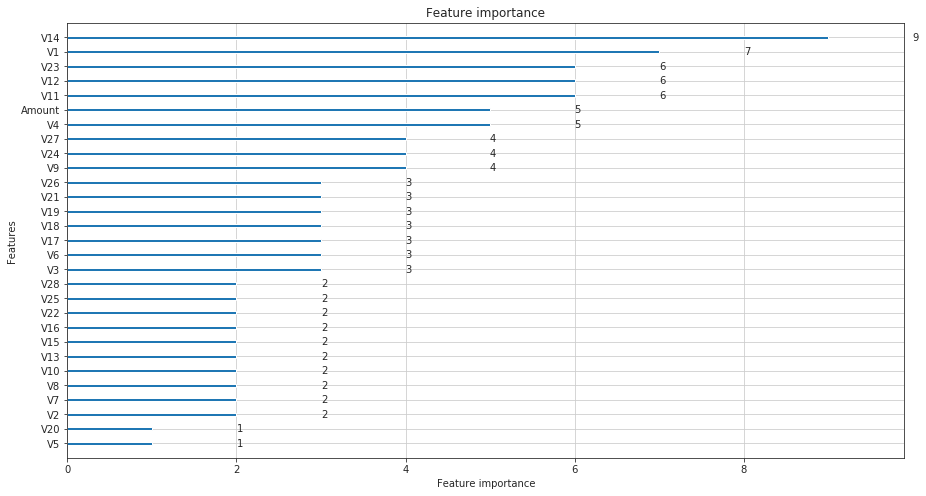

In [24]:
lgb.plot_importance(lgbm,max_num_features=29,importance_type="split",figsize=(15,8))

Plot the confusion matrix

[[70816   263]
 [   18   105]]


<Figure size 432x288 with 0 Axes>

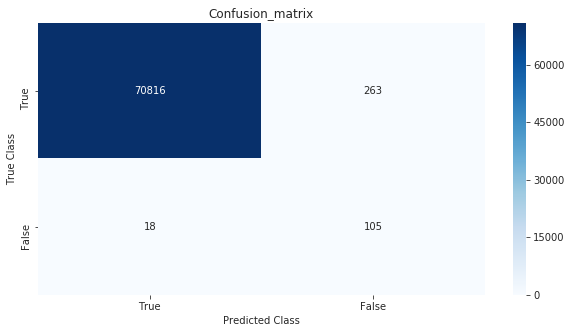

In [25]:
plt.figure()
#confusion matrix
cm=confusion_matrix(y_test,lgbm_predict)
print(cm)
labels=['True','False']
plt.figure(figsize=(10,5))
sns.heatmap(cm,xticklabels=labels,yticklabels=labels,cmap='Blues',vmin=0.2,annot=True,fmt='d')
plt.title('Confusion_matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

**Classification report**

In [26]:
#printing the classification report
print(classification_report(y_test,lgbm_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.29      0.85      0.43       123

   micro avg       1.00      1.00      1.00     71202
   macro avg       0.64      0.92      0.71     71202
weighted avg       1.00      1.00      1.00     71202



**Conclusion:-**

The both LightGBM and SMOTE models are performed well on imbalance data based on area under the roc curve.

**Submission**

In [27]:
#submitting the prediction results
sub_df=pd.DataFrame(data=lgbm_predict_prob,columns=['lgbm_pred'])
sub_df['smote_pred']=smote_pred
#Save to csv file
sub_df.to_csv('submission.csv',index=False)